In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import ipywidgets as widgets
import torch.nn.functional as F

Basic data setup

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])


mnist_data = datasets.MNIST(root='./data', train = True, download = True, transform = transform)

data_loader = torch.utils.data.DataLoader(dataset = mnist_data, batch_size = 64, shuffle = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...


/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


Using Dicrete GPU

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Generic Linear Autoencoder

In [4]:
class AutoencoderLinear(nn.Module):
    def __init__(self):
        
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
            
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return decoded

In [5]:
autoencoder = AutoencoderLinear()
loss_metric = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr = 1e-3, weight_decay = 1e-5)

In [6]:
autoencoder.to(device)

AutoencoderLinear(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

Training

In [7]:
num_epochs = 10
outputs = []

for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.to(device)
        img = img.reshape(-1, 28*28)
        recon = autoencoder(img)
        loss = loss_metric(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0470
Epoch:2, Loss:0.0480
Epoch:3, Loss:0.0399
Epoch:4, Loss:0.0390
Epoch:5, Loss:0.0341
Epoch:6, Loss:0.0308
Epoch:7, Loss:0.0353
Epoch:8, Loss:0.0286
Epoch:9, Loss:0.0326
Epoch:10, Loss:0.0320


Displaying Results

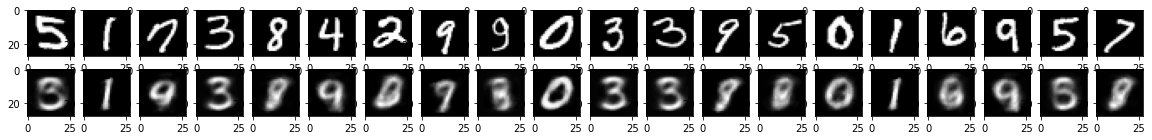

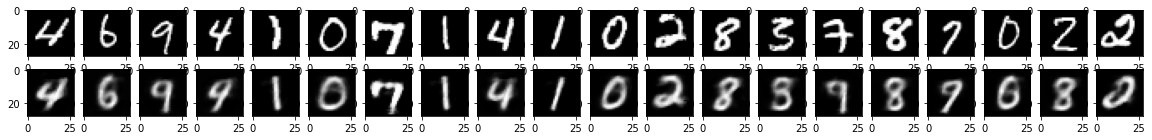

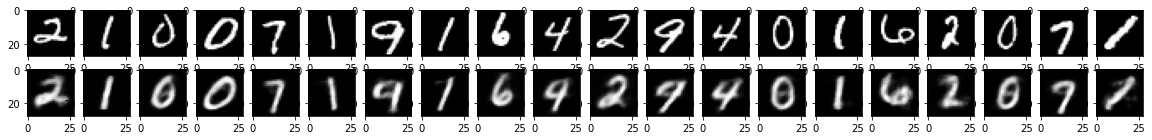

In [8]:
num_imgs = 20
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(num_imgs, 2))
    plt.gray()
    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    
    for i, item in enumerate(imgs):
        if i >= num_imgs: break
        plt.subplot(2, num_imgs, i+1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= num_imgs: break
        plt.subplot(2, num_imgs, num_imgs+i+1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])  

Generic CNN Autoencoder

In [9]:
class AutoencoderConv(nn.Module):
    def __init__(self):
        
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
            
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride = 2, padding = 1, output_padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride = 2, padding = 1, output_padding = 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return decoded

In [10]:
autoencoder = AutoencoderConv()
loss_metric = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr = 1e-3, weight_decay = 1e-5)

In [11]:
autoencoder.to(device)

AutoencoderConv(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

Training

In [12]:
num_epochs = 10
outputs = []

for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.to(device)
        
        recon = autoencoder(img)
        loss = loss_metric(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0087
Epoch:2, Loss:0.0060
Epoch:3, Loss:0.0040
Epoch:4, Loss:0.0029
Epoch:5, Loss:0.0034
Epoch:6, Loss:0.0032
Epoch:7, Loss:0.0037
Epoch:8, Loss:0.0029
Epoch:9, Loss:0.0024
Epoch:10, Loss:0.0028


Displaying Results

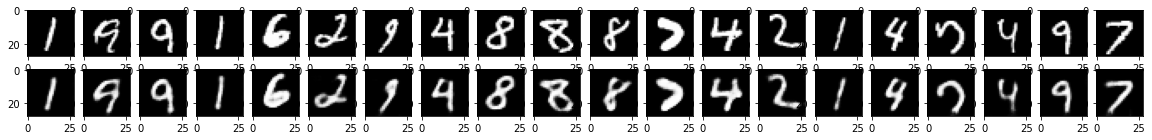

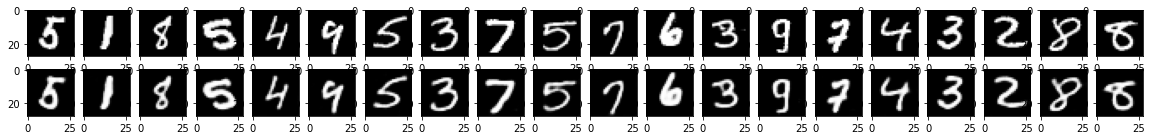

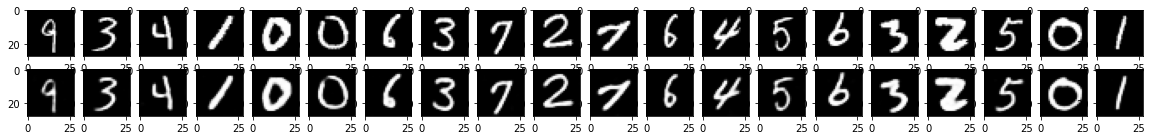

In [13]:
num_imgs = 20
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(num_imgs, 2))
    plt.gray()
    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    
    for i, item in enumerate(imgs):
        if i >= num_imgs: break
        plt.subplot(2, num_imgs, i+1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= num_imgs: break
        plt.subplot(2, num_imgs, num_imgs+i+1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

Variational Autoencoder

Dataset setup

In [36]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

mnist_data_trained = datasets.MNIST(root='./data', train = True, download = True, transform = transform)
mnist_data_untrained = datasets.MNIST(root='./data', train = False, download = True, transform = transform)

train_loader = torch.utils.data.DataLoader(dataset = mnist_data_trained, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = mnist_data_untrained, batch_size = 64, shuffle = False)

Hyperparameters

In [37]:
num_dims = 10
batch_size = 64
epochs = 50
lr = 0.0001

Vaeirational Autoencoder class

In [38]:
class LinearVAE(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_dims*2) 
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(num_dims, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu, log_var):
        
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std) 
        sample = mu + (eps * std) 
        
        return sample
    
    def decode(self, vec):
        x = self.decoder(vec)
        return x.reshape((-1, 1, 28, 28))
        
    def forward(self, x):
        
        encoded = self.encoder(x).view(-1, 2, num_dims)
        
        mu = encoded[:, 0, :] 
        log_var = encoded[:, 1, :] 
        
        z = self.reparameterize(mu, log_var)
        
        decoded = self.decoder(z)
        
        return decoded, mu, log_var

In [39]:
linearVAE = LinearVAE()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

linearVAE.to(device)

print(device)

cuda:0


Setting up optimizer and (partial) loss function (called "criterion")

In [40]:
optimizer = optim.Adam(linearVAE.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

Function for calculating the final loss metric

In [41]:
def final_loss(bce_loss, mu, logvar):

    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

Training

In [42]:
losses = []

for epoch in range(epochs):
    linearVAE.train()
    total_loss = 0
    
    for batch_idx, (img, _) in enumerate(train_loader):
            
        img = img
        img = img.to(device)
        img = img.view(img.size(0), -1)
        optimizer.zero_grad()
            
        decoded, mu, logvar = linearVAE(img)
        bce_loss = criterion(decoded, img)
        loss = final_loss(bce_loss, mu, logvar)
            
        total_loss += loss
        loss.backward()
            
        optimizer.step() 
            
    total_loss = total_loss/len(train_loader.dataset)
    print('Epoch: ', epoch+1, 'Loss: ', total_loss)
    losses.append(total_loss.detach().cpu().numpy())

Epoch:  1 Loss:  tensor(216.0725, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  2 Loss:  tensor(179.3778, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  3 Loss:  tensor(154.9254, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  4 Loss:  tensor(141.8692, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  5 Loss:  tensor(136.3080, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  6 Loss:  tensor(132.0468, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  7 Loss:  tensor(128.5103, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  8 Loss:  tensor(126.0257, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  9 Loss:  tensor(123.7495, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  10 Loss:  tensor(121.6307, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  11 Loss:  tensor(119.9520, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  12 Loss:  tensor(118.4906, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  13 Loss:  tensor(117.2332, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  14 Loss:  ten

Graphing loss curve

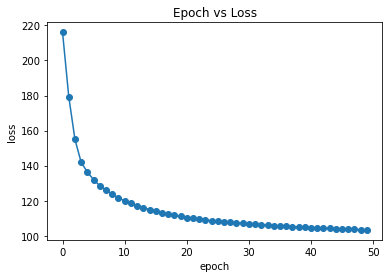

In [43]:
plt.plot(losses,'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Epoch vs Loss')
 
plt.show()

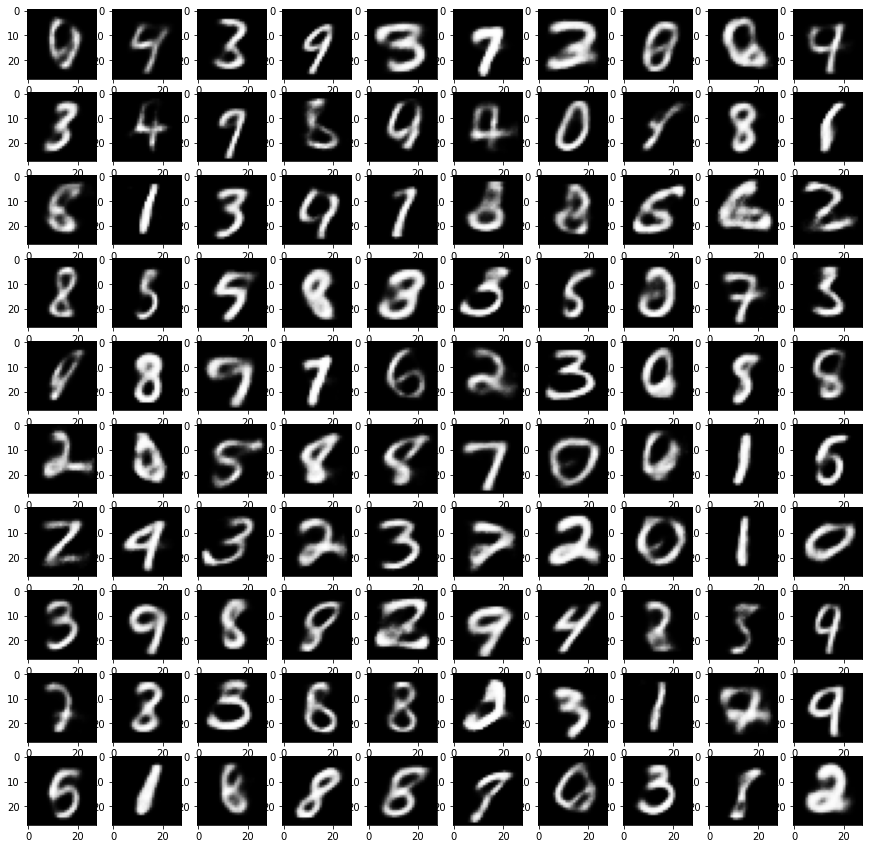

In [44]:
imgs = 10
f, axarr = plt.subplots(imgs,imgs)
f.set_figheight(15)
f.set_figwidth(15)
for x in range(imgs):
    for y in range(imgs):
        random = torch.randn(10).to(device)
        image = linearVAE.decode(random).reshape(28,28)
        image = image.detach().cpu().numpy()
        axarr[x,y].imshow(image)

In [46]:
slider1 = widgets.FloatSlider(value = 0.0, min = -3, max = 3, step = 0.001, description = "Parameter 1",
                              disabled = False,
                              continuous_update = False,
                              orientation = 'horizontal',
                              readout_format='.3f')

slider2 = widgets.FloatSlider(value = 0.0, min = -3, max = 3, step = 0.001, description = "Parameter 2",
                              disabled = False,
                              continuous_update = False,
                              orientation = 'horizontal',
                              readout_format='.3f')

slider3 = widgets.FloatSlider(value = 0.0, min = -3, max = 3, step = 0.001, description = "Parameter 3",
                              disabled = False,
                              continuous_update = False,
                              orientation = 'horizontal',
                              readout_format='.3f')

slider4 = widgets.FloatSlider(value = 0.0, min = -3, max = 3, step = 0.001, description = "Parameter 4",
                              disabled = False,
                              continuous_update = False,
                              orientation = 'horizontal',
                              readout_format='.3f')

slider5 = widgets.FloatSlider(value = 0.0, min = -3, max = 3, step = 0.001, description = "Parameter 5",
                              disabled = False,
                              continuous_update = False,
                              orientation = 'horizontal',
                              readout_format='.3f')

slider6 = widgets.FloatSlider(value = 0.0, min = -3, max = 3, step = 0.001, description = "Parameter 6",
                              disabled = False,
                              continuous_update = False,
                              orientation = 'horizontal',
                              readout_format='.3f')

slider7 = widgets.FloatSlider(value = 0.0, min = -3, max = 3, step = 0.001, description = "Parameter 7",
                              disabled = False,
                              continuous_update = False,
                              orientation = 'horizontal',
                              readout_format='.3f')

slider8 = widgets.FloatSlider(value = 0.0, min = -3, max = 3, step = 0.001, description = "Parameter 8",
                              disabled = False,
                              continuous_update = False,
                              orientation = 'horizontal',
                              readout_format='.3f')

slider9 = widgets.FloatSlider(value = 0.0, min = -3, max = 3, step = 0.001, description = "Parameter 9",
                              disabled = False,
                              continuous_update = False,
                              orientation = 'horizontal',
                              readout_format='.3f')

slider10 = widgets.FloatSlider(value = 0.0, min = -3, max = 3, step = 0.001, description = "Parameter 10",
                              disabled = False,
                              continuous_update = False,
                              orientation = 'horizontal',
                              readout_format='.3f')

def update_params(a, b, c, d, e, f, g, h, i, j):
    params = torch.tensor([a, b, c, d, e, f, g, h, i, j])
    params = params.to(device)
    img = linearVAE.decode(params).reshape(28,28)
    img = img.detach().cpu().numpy()
    plt.imshow(img)

i = widgets.interact(update_params, 
                    a = slider1,
                    b = slider2,
                    c = slider3,
                    d = slider4,
                    e = slider5,
                    f = slider6,
                    g = slider7,
                    h = slider8,
                    i = slider9,
                    j = slider10)

#Number 0: Parameter 5 Pos Extreme
#Number 1: Parameter 5 Neg Extreme
#Number 2: Parameter 6 Neg Extreme, Parameter 9 Pos Extreme
#Number 3: Parameter 3 Pos Extreme
#Number 4: Parameter 6 Pos Extreme
#Number 5: Parameter 7 Pos Extreme, Parameter 9 Neg Extreme
#Number 6: Parameter 4 Pos Extreme, Parameter 6 Pos Extreme
#Number 7: Parameter 4 Neg Extreme
#Number 8:
#Number 9:

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Parameter 1', max=3.0, min=…

In [177]:
num_dims = 10
batch_size = 64
epochs = 50
lr = 0.001

In [178]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

mnist_data_trained = datasets.MNIST(root='./data', train = True, download = True, transform = transform)
mnist_data_untrained = datasets.MNIST(root='./data', train = False, download = True, transform = transform)

train_loader = torch.utils.data.DataLoader(dataset = mnist_data_trained, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = mnist_data_untrained, batch_size = 64, shuffle = False)

In [179]:
class ConvVAE(nn.Module):
    def __init__(self):
        
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride = 2, padding = 1, output_padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride = 2, padding = 1, output_padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride = 2, padding = 1, output_padding = 1),
            nn.Sigmoid()
        )
        
        self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, num_dims)
        self.fc_log_var = nn.Linear(128, num_dims)
        self.fc2 = nn.Linear(num_dims, 64)
        
    def reparameterize(self, mu, log_var):
        
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std) 
        sample = mu + (eps * std) 
        
        return sample
    
    def decode(self, vec):
        x = self.fc2(vec)
        x = x.view(-1, 64, 1, 1)
        x = self.decoder(x)
        return x.reshape((-1, 1, 32, 32))
    
    def forward(self, x):
        encoded = self.encoder(x)
        
        batch, _, _, _ = encoded.shape
        
        encoded = F.adaptive_avg_pool2d(encoded, 1).reshape(batch, -1)
        
        encoded = self.fc1(encoded)
        mu = self.fc_mu(encoded)
        log_var = self.fc_log_var(encoded)
        
        encoded = self.reparameterize(mu, log_var)
        encoded = self.fc2(encoded)
        encoded = encoded.view(-1, 64, 1, 1)
        
        decoded = self.decoder(encoded)
        
        return decoded, mu, log_var

In [180]:
convVAE = ConvVAE()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

convVAE.to(device)

print(device)

cuda:0


In [181]:
optimizer = optim.Adam(convVAE.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

In [182]:
def final_loss2(bce_loss, mu, logvar):

    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [183]:
losses = []

for epoch in range(epochs):
    convVAE.train()
    total_loss = 0
    
    for batch_idx, (img, _) in enumerate(train_loader):
            
        img = img
        img = img.to(device)
        optimizer.zero_grad()
            
        decoded, mu, logvar = convVAE(img)
        bce_loss = criterion(decoded, img)
        loss = final_loss2(bce_loss, mu, logvar)
            
        total_loss += loss
        loss.backward()
            
        optimizer.step() 
            
    total_loss = total_loss/len(train_loader.dataset)
    print('Epoch: ', epoch+1, 'Loss: ', total_loss)
    losses.append(total_loss.detach().cpu().numpy())

KeyboardInterrupt: 

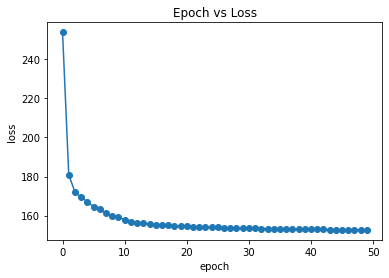

In [69]:
plt.plot(losses,'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Epoch vs Loss')
 
plt.show()

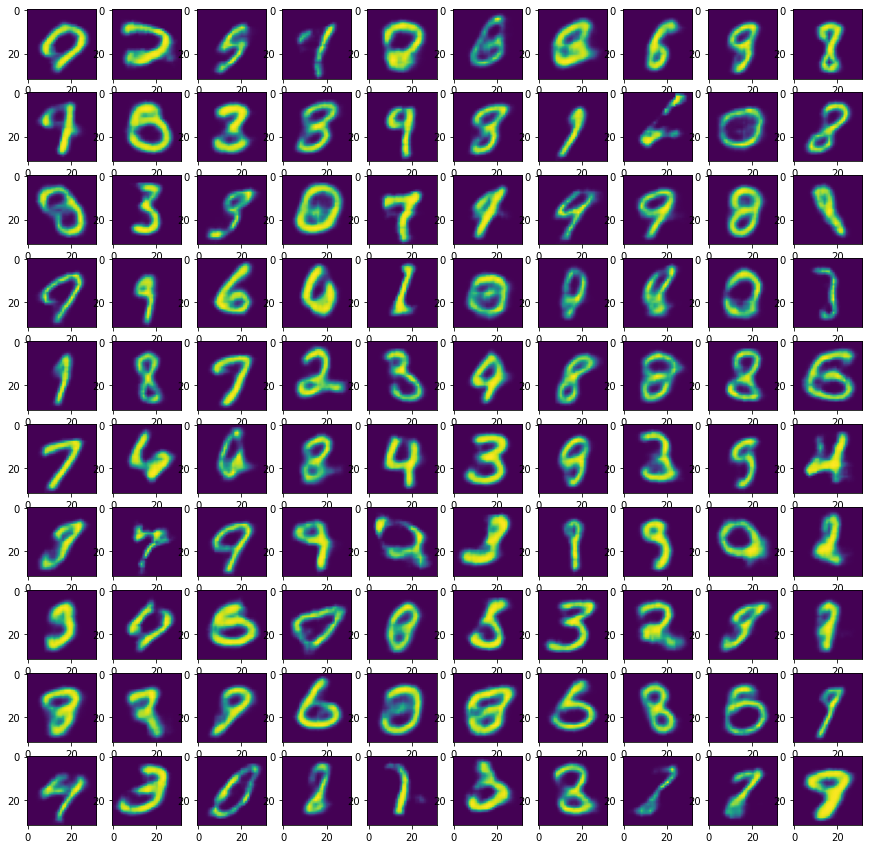

In [70]:
imgs = 10
f, axarr = plt.subplots(imgs,imgs)
f.set_figheight(15)
f.set_figwidth(15)
for x in range(imgs):
    for y in range(imgs):
        random = torch.randn(10).to(device)
        image = convVAE.decode(random).reshape(32,32)
        image = image.detach().cpu().numpy()
        axarr[x,y].imshow(image)

In [72]:
slider1 = widgets.FloatSlider(value = 0.0, min = -3, max = 3, step = 0.001, description = "Parameter 1",
                              disabled = False,
                              continuous_update = False,
                              orientation = 'horizontal',
                              readout_format='.3f')

slider2 = widgets.FloatSlider(value = 0.0, min = -3, max = 3, step = 0.001, description = "Parameter 2",
                              disabled = False,
                              continuous_update = False,
                              orientation = 'horizontal',
                              readout_format='.3f')

slider3 = widgets.FloatSlider(value = 0.0, min = -3, max = 3, step = 0.001, description = "Parameter 3",
                              disabled = False,
                              continuous_update = False,
                              orientation = 'horizontal',
                              readout_format='.3f')

slider4 = widgets.FloatSlider(value = 0.0, min = -3, max = 3, step = 0.001, description = "Parameter 4",
                              disabled = False,
                              continuous_update = False,
                              orientation = 'horizontal',
                              readout_format='.3f')

slider5 = widgets.FloatSlider(value = 0.0, min = -3, max = 3, step = 0.001, description = "Parameter 5",
                              disabled = False,
                              continuous_update = False,
                              orientation = 'horizontal',
                              readout_format='.3f')

slider6 = widgets.FloatSlider(value = 0.0, min = -3, max = 3, step = 0.001, description = "Parameter 6",
                              disabled = False,
                              continuous_update = False,
                              orientation = 'horizontal',
                              readout_format='.3f')

slider7 = widgets.FloatSlider(value = 0.0, min = -3, max = 3, step = 0.001, description = "Parameter 7",
                              disabled = False,
                              continuous_update = False,
                              orientation = 'horizontal',
                              readout_format='.3f')

slider8 = widgets.FloatSlider(value = 0.0, min = -3, max = 3, step = 0.001, description = "Parameter 8",
                              disabled = False,
                              continuous_update = False,
                              orientation = 'horizontal',
                              readout_format='.3f')

slider9 = widgets.FloatSlider(value = 0.0, min = -3, max = 3, step = 0.001, description = "Parameter 9",
                              disabled = False,
                              continuous_update = False,
                              orientation = 'horizontal',
                              readout_format='.3f')

slider10 = widgets.FloatSlider(value = 0.0, min = -3, max = 3, step = 0.001, description = "Parameter 10",
                              disabled = False,
                              continuous_update = False,
                              orientation = 'horizontal',
                              readout_format='.3f')

def update_params2(a, b, c, d, e, f, g, h, i, j):
    params = torch.tensor([a, b, c, d, e, f, g, h, i, j])
    params = params.to(device)
    img = convVAE.decode(params).reshape(32,32)
    img = img.detach().cpu().numpy()
    plt.imshow(img)

i = widgets.interact(update_params2, 
                    a = slider1,
                    b = slider2,
                    c = slider3,
                    d = slider4,
                    e = slider5,
                    f = slider6,
                    g = slider7,
                    h = slider8,
                    i = slider9,
                    j = slider10)



interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Parameter 1', max=3.0, min=…